## **2016311707 성예슬 딥러닝 프로젝트 : 네이버 영화 리뷰 긍정부정 예측**

### **딥러닝 네이버 영화 평점예측 모델 만들기**

**원래 계획**
1. BeautifulSoup, selenium으로 각각 최근 7년도 영화 정보(제목, 장르, 줄거리, 평점, 출연진 등) / 영화 댓글을 크롤링해 각각의 데이터셋으로 저장 후 두 데이터셋을 영화 댓글 데이터셋 기준으로 병합
2. 은전한닢 형태소분석기(mecab)을 활용하여 형태소 분리, 특히 영화 줄거리의 고유명사나 리뷰 댓글의 비속어, 이모티콘, 줄임말 등등은 따로 사용자정의사전에 추가
3. 병합된 데이터셋에 있는 정보 : (영화 제목, 댓글, 댓글을 남긴 사람의 아이디, 댓글과 함께 남긴 개별 평점, 줄거리, 장르, 전체 평점, 출연진) 을 바탕으로 

	1) 우선 개개인의 댓글을 바탕으로 개별 평점(해당 id가 해당 영화에 남긴 평점을 댓글로 예측)하는 딥러닝 모델을 만든다

	2) 예측한 평점을 실제 평점과 비교하여 정확도를 계산한다 (모델 평가 기준)

	3) 예측한 평점을 실제 평점처럼 취급하여 각각 id별로 선호할 영화를 추천하는 시스템을 만든다 
    
    (콘텐츠 기반 추천/사용자 id 및 평점을 활용한 특이값 분해 각각 활용, top 3개씩 뽑아 추천)

**문제점**
1. 데이터 크롤링 : 네이버 영화 정보를 크롤링 시에는 문제 X 

	다만 네이버 영화 댓글 및 개별 평점을 크롤링할 때 사용자 아이디가 블라인드되는 것을 확인 > 사용자 기반 추천시스템 불가

**대안**
1. Naver sentiment movie corpus v1.0을 사용

	사용자 id, 댓글(data), 긍정/부정(target : 0, 1)로 구성

	1-10까지의 평점을 예측하는 것이 아니라 1-4까지는 부정, 9-10은 긍정으로 처리해 binary output으로 처리함

	개별 평점과 리뷰 넘버가 나와 있지만 어떤 영화에 대한 댓글인지는 나와 있지 않아 영화 추천 모델을 만들 수 없음.

2. MovieLens dataset을 사용

	사용자 id, 사용자 개별 평점, 영화 정보 등이 다양하게 들어 있는 데이터셋이 여러 개 존재하고, 필요한 정보를 가진 데이터셋을 병합해서 사용하면 되는 구조. 
    
    (R의 nycflights13 패키지 안의 flights, weather, airports같은 개념)

	문제는 댓글을 제공하지 않으므로 형태소 분석기를 사용할 수 없게 됨

3. 직접 크롤링한 데이터를 사용하되, 기존의 연구처럼 리뷰의 평점을 단순히 긍정/부정으로 예측하는 것이 아닌 1-10 사이의 값으로 예측하는 모델을 만들고 아쉽지만 사용자 추천 시스템은 이번 프로젝트에서는 포기하기로 함
4. 하지만 다시 문제가 생김 : 크롤링을 직접 하기에는 아직 실력이 부족한데, 내가 아는 방법으로는 1000페이지까지의 리뷰만큼만 크롤링해올 수 있었음. 데이터셋의 총 크기가 10000개밖에 되지 않았고, 그마저도 자연어처리 정제 과정에서 결측치가 발생할 가능성이 있었음. 게다가 심각한 imbalanced data이고, target 예측을 위해 사용될 feature들이 자연어이다 보니 SMOTE등의 오버샘플링 기법도 사용하기 힘든 상황(그리고 애초에 오버샘플링 자체를 그리 선호하지 않음..)
5. 결국 처음 대안으로 고려했던 nsmc 데이터를 사용하여 긍정/부정으로 데이터를 예측하기로 함. 

**수정된 계획**

Naver sentiment movie corpus 데이터셋을 사용함
1. 데이터 전처리

	1) 형태소 분석기가 잘 인식하지 못하는 단어(줄임말, 이모티콘, 비속어 등)들을 따로 사용자 정의 사전에 추가, 유의미한 형태소만을 남길 때 잘못 제거하는 일이 없도록 함

	2) 형태소 분석기를 사용하여 유의미한 형태소(체언, 용언 어간, 부사)만을 추출

	3) 형태소 추출 후 남은 문자열이 없거나, 기본적인 값이 누락된 행이 있을 수 있으니 각 열의 결측값의 개수를 확인하고 전체 데이터 크기에 비해 무시할 만큼 작으면 해당 열들 삭제

    4) 데이터를 train, test dataset으로 분리

	5) 문자열 데이터 토큰 > sequence > 벡터화

2. 모델링

    1) LSTM

    2) Bidirectional LSTM

    3) Bidirectional LSTM + Bahdanau Attention

## **1. 데이터 전처리**

**먼저 필요한 모듈을 불러와 주고, 구글 드라이브를 마운트한다**

구글 드라이브 마운트는 데이터셋을 업로드하기 위해서도 있지만, 곧 활용할 형태소 분석기의 성능을 높이는 과정 때문

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**드라이브에서 저장된 데이터 불러오기**

텍스트 파일로 저장되어 있고, 쉼표가 아닌 탭으로 구분되어 있기 때문에 따로 지정해줌

리뷰 번호, 리뷰 내용(data), 리뷰 긍정/부정(target)으로 이루어져 있음

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/ratings.txt"
df1 = pd.read_csv(filename, sep = "\t", encoding = "utf-8")
df1.head() #id, document : input / rating : target

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### **1-1) 사용자정의사전 형태소분석기에 추가** 

은전한닢 형태소분석기(Mecab)을 구글 코랩에서 사용하기 위해서는 별도의 설치 과정이 필요함

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [ ]:
cd/content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
 cd Mecab-ko-for-Google-Colab

/content/drive/MyDrive/Colab Notebooks/Mecab-ko-for-Google-Colab


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.1MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 460kB 31.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-06-02 07:20:35--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=j7uSBEImHVlP0SVal9XlcK3sguE%3D&Expires=1622619839&AWSAccessKeyId=AKIA6KOSE3BNJR

In [ ]:
cd

/root


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


**만들어둔 사용자정의사전의 위치를 구글 드라이브 내의 형태소 프로그램 사전 위치로 옮겨 준다**



In [ ]:
mv user_dic_test.csv /content/mecab-ko-dic-2.1.1-20180720/user-dic

mv: cannot stat 'user_dic_test.csv': No such file or directory


**상위 디렉토리로 빠져나온 후 mecab-ko-dic-2.1.1-20180720 폴더로 이동**

In [ ]:
cd

/root


In [ ]:
cd /content/mecab-ko-dic-2.1.1-20180720

/content/mecab-ko-dic-2.1.1-20180720


**사용자 정의 사전을 compile하는 과정**

In [ ]:
!bash ./tools/add-userdic.sh

generating userdic...
nnp.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/nnp.csv ... 
done!
person.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/person.csv ... 
done!
place.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/place.csv ... 
done!
test -z "model.bin matrix.bin char.bin sys.dic unk.dic" || rm -f model.bin matrix.bin char.bin sys.dic unk.dic
/usr/local/libexec/mecab/mecab-dict-index -d . -o . -f UTF-8 -t UTF-8
reading ./unk.def ... 13
emitting double-array: 100% |###########################################| 
reading ./VA.csv ... 2360
reading ./XSN.csv ... 124
reading ./NP.csv ... 342
reading ./Hanja.csv ... 1

In [ ]:
!make install

make[1]: Entering directory '/content/mecab-ko-dic-2.1.1-20180720'
make[1]: Nothing to be done for 'install-exec-am'.
 /bin/mkdir -p '/usr/local/lib/mecab/dic/mecab-ko-dic'
 /usr/bin/install -c -m 644 model.bin matrix.bin char.bin sys.dic unk.dic left-id.def right-id.def rewrite.def pos-id.def dicrc '/usr/local/lib/mecab/dic/mecab-ko-dic'
make[1]: Leaving directory '/content/mecab-ko-dic-2.1.1-20180720'


In [ ]:
pip install konlpy

**성공적으로 사전 내용 반영 완료!**


### **1-2) 형태소 분석기로 의미있는 형태소 추출**

**아까 설치해둔 은전한닢(Mecab)을 불러와준다**

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()

기존 데이터셋에서 문자열과 공백만 남기고 나머지 삭제

In [ ]:
df2 = df1.copy()
df2['document'] = df2['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df2

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ,0
199996,3302770,쓰레기,0
199997,5458175,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


**결측치 삭제**

만약 문자열 데이터가 missing이면 아래에 만들 형태소 분석기를 활용한 데이터 전처리 과정이 잘 돌아가지 않는다.

따라서 결측치가 얼마나 있는지 확인하고, 결측치의 개수가 그리 많지 않다면 해당 행을 제거한다

만약 id열에 결측치가 있는 경우에는 해당 행을 제거하지 않는다. (id열은 활용할 변수가 아니므로)

In [ ]:
#find missing values
df2.isnull().sum() #total 8 missing in document
df3 = df2.dropna(how = "any")
df3.isnull().sum()

id          0
document    0
label       0
dtype: int64

**인덱스 재정렬**

아래에서 진행할 데이터 전처리는 데이터셋의 인덱스를 활용하기 때문에, 결측치를 제거하며 조금씩 밀린 인덱스를 재정렬해준다.

In [ ]:
df4 = df3.reset_index(drop = True)
df4

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...,...
199987,8963373,포켓 몬스터 짜가 ㅡㅡ,0
199988,3302770,쓰레기,0
199989,5458175,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0
199990,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


**형태소분석기를 통해 의미있는 형태소만 필터링하는 작업**

1. 데이터셋의 document 열의 인덱스와 데이터를 행별로 차례대로 넣는다
2. Mecab.pos()에 해당 행의 리뷰를 넣으면 (형태소, 품사)의 튜플을 여러 개 반환한다.
3. 해당 행의 형태소들에 각각 해당하는 튜플마다 품사가 체언, 용언 어간, 부사 중 하나인지 체크하고 (품사 태깅의 첫 번째 글자가 각각 N, V, M으로 시작) 해당사항이 있으면 clean_words에 넣는다.
4. list 형태의 clean_words를 하나의 string으로 합친 다음 데이터셋의 해당 열에 넣어 준다

In [ ]:
df_pp = df4.copy()
for i, doc in enumerate(df_pp["document"]):
    tokenizer = Mecab()
    clean_words = []
    for word in tokenizer.pos(doc): #어간 추출
        if word[1][0] in ["N", "V", "M"]:
            clean_words.append(word[0])
    doc1 = " ".join(clean_words)
    print(doc1)
    df_pp["document"][i] = doc1
print(df_pp)

어릴 때 보 지금 다시 봐도 재밌
디자인 배우 학생 외국 디자이너 그 일군 전통 통해 발전 가 문화 산업 부러웠 사실 우리 나라 그 어려운 시절 끝 열정 지킨 노라노 같 전통 있 저 같 사람 꿈 꾸 이뤄나갈 수 있 것 감사
폴리스 스토리 시리즈 뉴 버릴 께 하나 없 최고
연기 진짜 개 쩔 생각 몰입 봤 이런 게 진짜 영화 지
안개 밤하늘 떠 있 초승달 같 영화
사랑 해 본 사람 이 처음 끝 웃 수 있 영화
완전 감동 입니다 다시 봐도 감동
개 전쟁 나오 나오 빠 보 싶
굿
바보 아니 병 쉰 인 듯
내 나이 같 영화 지금 본 나 감동 이 하지만 훗날 다시 보면대 사 하나 하나 그 감정 완벽 이해 것 같
재밌
고질라 니무 귀엽
영화 오페라 라고 해야 할 작품 극단 평갈 림 어쩔 수 없 듯
반전 좋
평점 왜 낮 긴장감 스릴감 진짜 최고 인데 진짜 전장 느끼 공포 전해준다
고시 이터 소재 같 뿐 아무런 관련 없
단연 최고
가 갈수록 더욱 빠져드 밀회 화이팅
생각없이 봤 상당 수작 일본 영화 년 내 최고 마음 들 임팩트 일품
오랜만 본 제대로 된 범죄 스릴러
그런 때 있 사랑 아니 그저 좋 한다는 한 마디 말 꺼내 벅차 밤 잠 설치 때 커 징 텅 교복 남 션 자이 볼펜 자국 역시 미처 다 전하 못한 마음 형태 인 거 다
마지막 씬 잊 수 없
강압 용서 세뇌 용서 대한 비판
중세 시대 명작 굿 평점 왜 이래
시간 영상 존재 죽 전 꼭 한번 보 싶 아름답 슬픈 제니퍼코넬리 눈부신 아역 시절 로버트드니로 마지막 웃 장면 정말 가슴 속 영원히 기억 최고 명작 이
사람 어떻 저런 짓 할 수 있 보 내 다 화나
인간 잠재 악마 여러 시간 공간 속 존속 왔 이 다큐 그것 광적 재현
최고 다 삼 일 동안 쉬 틈틈이 잠 줄여 가 봤 여운 남
실화 여서 더욱 충격 다시 어디 일어나 안 될 경각심 일깨워 주 영화
존 그라 작품 이 한 번 볼 가치 있
농아 인 문화 대한 알 합니다
이거 어렸 때 되게 재밌 봄 이정재 이범수 연기
친구 우정 매우 감동 이
굿 굿 굿 또 해라 또 해라 제발
재

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
이혜은 당시 이 영화 땜시 자신 몸 무계 늘렸
년 간 지배했 이렇게 빨리 무너지
젠 젠 모에 않 여주 안정 인 국산 얼룩소 우 웩
와 생각난다 기대 거 너무 재미없 영화 근데 그것 넌 나 모욕감 줬 영화 자체 점정 주 개인 인 이유 점
터무니 관객 속이 들 말 맞서 제군
끝내 주 못 만들 몇 번 걸쳐서 띄엄 띄엄 힘들 봤 유역비 때문 그나마 점 줌
이게 대체 뭐 야 볼 거 못 된다
거장 김문옥 감독 년 작품 왜 거장 인지 알 수 잇 해 주 영화
와
시도 좋 근데 그게 다임
뭐 니 이거
너무 신음 소리 내 야한 것 모르 스토리 개 이 없이 해서 웃 김
연기 시나리오 별로 하나 안 웃긴다
년 영화 수준 이거 안 되 개인 내 볼땐 다 세포 맞먹
평점 봐도 내용 알
바쁜 인생 사 이런 것 챙겨서 보 쉽 않
감독 무슨 생각 이런 영화 만들 모르 이게 무슨 년 나올 법 영화 인가 정말 재미없 스토리 개 엉망 이 둘 다 연기 정말 못 함 최악 영화 중 하나 완전 비추 보 후회
더 빙 때문 안 본다
쓸데없 장면 너무 많 연기 스토리 감독 나 장난
해 줘서 보 있 킬링 타임 아닌 나 지금 하 있 깨달 주 영화
사실 관람 전 별 다른 기대 하 않 관람 후 기대 하 않 점 무척 다행 이 생각 추가 음악 이 라는 영화 떠 오 릴 것 큰 수확
년 최고 오락 영화 기억 재미 있 작품 평가 위해서
그 이야기 나 공감 다가오 않 뿐 특유 여유 가운데 일본 눈밭 다녀온 두 시간 그것 만족
스토리 미흡 영상 혼잡 제 취향 아닌 듯
작품 논하 싶 김기덕 살아오 여자 어떤 상처 입 마 막 인상 인데 김기덕 감독 가사 알 실
내 생애 줄 요약 가능 영화 처음 다 처음 끝 뻔한 게 오히려 반전 인 영화 골프 대해서 제대로 나오 않
산드라블록 남자 주인공 사이 전혀 화학 작용 일어나 않 영화
쓰레기 중 하나 꼽히 한국 액션 영화 못 한 이딴 거 가지 감히 본 시리즈
더 잘 만들 수 있 시나리오 갖 작품 내 원작 설정 붕괴 작품 외 작화 

### **1-3) 데이터 결측치 제거**

최종적으로 정제된 데이터 중 문자열이 없는 행이 있는지 확인한다

(아까 결측치가 있는 행을 삭제했지만, 필터링 후에는 의미없는 형태소로만 이루어진 리뷰의 경우 모든 내용이 삭제되어 공백만 남기 때문)

이때 필터링 기준을 isnull()함수로 잡으면 안 되고, 문자열의 길이가 0인 행들을 삭제해 줘야 한다.

마찬가지로 전체 크기에 비해 무시해도 될 정도로 작다면 해당 행을 제거한다.

In [ ]:
print(df_pp.isnull().sum())
print(df_pp.query("document == ''"))

id          0
document    0
label       0
dtype: int64
              id document  label
86      10248728               1
111      6906147               1
120      4083134               1
190      7059515               1
203     10216462               1
...          ...      ...    ...
199675   2205229               0
199746   9157025               0
199840   7727438               0
199868   8257744               0
199931   2105796               0

[3046 rows x 3 columns]


다행히도 정제된 데이터에서 제거해야 할 행은 없는 듯 했으나..

데이터의 길이를 보니 빈 문자열이 있는 행들이 존재한다.



In [ ]:
idx = df_pp.query("document == ''").index
final = df_pp.drop(idx, axis = 0).reset_index(drop = True)
final

,id,document,label
0,8112052,어릴 때 보 지금 다시 봐도 재밌,1
1,8132799,디자인 배우 학생 외국 디자이너 그 일군 전통 통해 발전 가 문화 산업 부러웠 사실...,1
2,4655635,폴리스 스토리 시리즈 뉴 버릴 께 하나 없 최고,1
3,9251303,연기 진짜 개 쩔 생각 몰입 봤 이런 게 진짜 영화 지,1
4,10067386,안개 밤하늘 떠 있 초승달 같 영화,1
...,...,...,...
196941,8963373,포켓 몬스터 짜 가,0
196942,3302770,쓰레기,0
196943,5458175,완전 사이코 영화 마지막 더욱더 이 영화 질 떨어트린 다,0
196944,6908648,왜 난 재미없 라따뚜이 보 나 스머프 봐서 그런가,0


**형태소 필터링 완료**


### **1-4) 학습 / 테스트 데이터 나누기**
이제 데이터를 학습/테스트 데이터로 나눠 주고 나머지 과정을 진행하려 한다.

학습 데이터와 테스트 데이터 간에 라벨 분포의 불균형이 없도록 stratify = y 옵션을 지정한 후 결과를 확인한다

In [ ]:
from sklearn.model_selection import train_test_split

X = final.drop("label", axis = 1)
y = final["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)
print(y_train.value_counts() / y_train.shape[0]*100)
print(y_test.value_counts() / y_test.shape[0]*100)

1    50.035543
0    49.964457
Name: label, dtype: float64
1    50.035543
0    49.964457
Name: label, dtype: float64


학습 / 테스트 데이터셋 간의 차이는 물론 라벨값에 따른 분포의 차이 역시 크지 않다. 따라서 별도의 불균형 해소 작업은 필요없어 보인다.

### **1-5) 데이터 토큰화 > sequence화 > 벡터화**

1 58


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


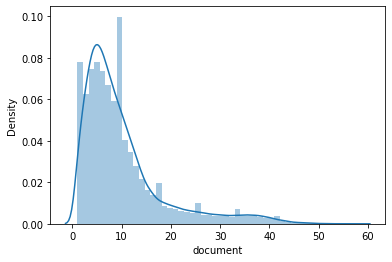

In [ ]:
length = X_train["document"].apply(lambda x: len(x.split()))
print(length.min(), length.max())
import seaborn as sns
sns.distplot(length)

각 리뷰마다 가지고 있는 단어(형태소)의 개수가 어떻게 분포하는지 확인

추후 sequence padding시 max_len을 설정하기 위해!

35개 또는 넉넉히 50개 정도가 적당해 보임

In [ ]:
from keras.preprocessing.text import Tokenizer
X_tr = X_train["document"].values
X_te = X_test["document"].values

tokenizer = Tokenizer(num_words = 35000)
tokenizer.fit_on_texts(X_tr)

In [ ]:
seq_tr = tokenizer.texts_to_sequences(X_tr)

In [ ]:
from keras.preprocessing import sequence
seq_mt = sequence.pad_sequences(seq_tr, maxlen = 35)
print(len(seq_mt))
print(seq_mt[0])

137862
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 9051 5212    2
  133 1358  616 4557 1550  810  304]


fit_on_text를 제외한 동일한 방법으로 test 데이터셋도 벡터화

In [ ]:
seq_te = tokenizer.texts_to_sequences(X_te)
seq_mte = sequence.pad_sequences(seq_te, maxlen = 35)



---

## **2. 모델 구성**

### **Model 1 : LSTM**

우선 Embedding layer을 깔아 주고 LSTM을 깔아 준 다음 Dense layer 2개를 깔아 준다. 

과적합 방지를 위해 dropout layer 역시 깔아 주고, 

마지막 출력 레이어는 binary output이니 sigmoid 함수를 사용한다.

(크롤링만 제대로 할 수 있었다면 softmax를 이용해서 평점 세분화 예측이 가능했겠지만... 종강 이후에 도전해볼 계획)

모델 학습 과정에서 데이터 양이 너무 많기도 하고 과적합이 우려되어 earlystopping callback을 지정해 두고 그에 맞게 epoch수를 15로 지정했다.

우선 한 번 돌려 보고 모델 성능에 따라 파라미터를 조절해볼 예정

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM, Dropout

model = Sequential()
model.add(Embedding(35000, 50, input_length = 35))
model.add(LSTM(64))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])


우선은 학습 데이터셋의 0.2프로를 validation set으로 빼내고,

earlystopping을 설정하지 않은 상태에서 epoch마다 학습 loss와 validation loss를 비교하여 어떤 양상을 보이는지 확인해볼 계획이다.

In [ ]:
history = model.fit(seq_mt, y_train, batch_size = 128, epochs = 15, validation_split = 0.2)

Epoch 1/15
862/862 [==============================] - 64s 74ms/step - loss: 0.1793 - accuracy: 0.9278 - val_loss: 0.5188 - val_accuracy: 0.8298
Epoch 2/15
862/862 [==============================] - 64s 74ms/step - loss: 0.1533 - accuracy: 0.9394 - val_loss: 0.5840 - val_accuracy: 0.8247
Epoch 3/15
862/862 [==============================] - 64s 74ms/step - loss: 0.1335 - accuracy: 0.9468 - val_loss: 0.6584 - val_accuracy: 0.8238
Epoch 4/15
862/862 [==============================] - 64s 74ms/step - loss: 0.1175 - accuracy: 0.9539 - val_loss: 0.7149 - val_accuracy: 0.8255
Epoch 5/15
862/862 [==============================] - 64s 74ms/step - loss: 0.1061 - accuracy: 0.9585 - val_loss: 0.7872 - val_accuracy: 0.8218
Epoch 6/15
862/862 [==============================] - 64s 74ms/step - loss: 0.0945 - accuracy: 0.9626 - val_loss: 0.8396 - val_accuracy: 0.8180
Epoch 7/15
862/862 [==============================] - 64s 74ms/step - loss: 0.0871 - accuracy: 0.9657 - val_loss: 0.8748 - val_accuracy:

1847/1847 [==============================] - 14s 8ms/step - loss: 1.4860 - accuracy: 0.8205
model 1 test accuracy : 0.8205
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 50)            1750000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 1,796,337
Trainable params: 1,796,337
Non-trainable params: 0
_____________________________________________________

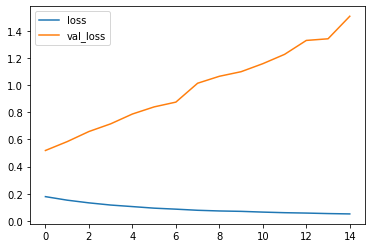

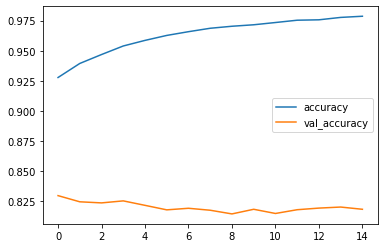

In [ ]:
print("model 1 test accuracy : {0:.4f}".format(model.evaluate(seq_mte, y_test)[1]))
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()
model.summary()

보다시피 validation loss는 한도끝도없이 쭉쭉 올라감을 확인할 수 있음.

validation split으로 각 epoch마다 0.2퍼센트의 학습 데이터셋을 검증 데이터셋으로 활용,


validation set에서의 loss가 더 이상 내려가지 않는 지점에서 학습을 중단하고자 함 (과적합 방지)


단 너무 일찍 학습을 중단하는 경우 문제가 생길 수 있으니 적어도 2번까지는 validation loss가 줄어들지 않아도 허용하기로 함

In [ ]:
model = Sequential()
model.add(Embedding(35000, 50, input_length = 35))
model.add(LSTM(64))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor = "val_loss", mode = "min", patience = 2) #validation split에서의 loss함수 기준으로 loss가 더이상 내려가지 않는 epoch에서 일찍 학습 중단, 2번까지는 허용
history1 = model.fit(seq_mt, y_train, batch_size = 128, epochs = 15, callbacks=[ES], validation_split = 0.2)

Epoch 1/15
862/862 [==============================] - 66s 74ms/step - loss: 0.4759 - accuracy: 0.7598 - val_loss: 0.3721 - val_accuracy: 0.8348
Epoch 2/15
862/862 [==============================] - 63s 73ms/step - loss: 0.3142 - accuracy: 0.8673 - val_loss: 0.3666 - val_accuracy: 0.8386
Epoch 3/15
862/862 [==============================] - 64s 74ms/step - loss: 0.2536 - accuracy: 0.8953 - val_loss: 0.3959 - val_accuracy: 0.8373
Epoch 4/15
862/862 [==============================] - 64s 74ms/step - loss: 0.2085 - accuracy: 0.9150 - val_loss: 0.4471 - val_accuracy: 0.8321


**학습시 loss vs validation loss**

**학습시 accuracy vs validation accuracy**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 50)            1750000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 1,796,337
Trainable params: 1,796,337
Non-trainable params: 0
_________________________________________________________________


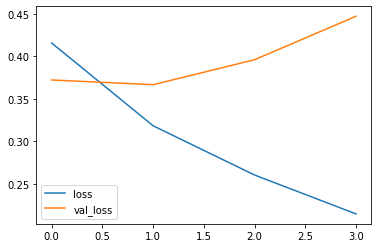

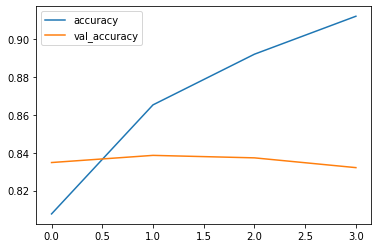

In [ ]:
pd.DataFrame(history1.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history1.history)[["accuracy", "val_accuracy"]].plot()
model.summary()

**테스트 데이터셋에서의 성능**

In [ ]:
print("model 1 test accuracy : {0:.4f}".format(model.evaluate(seq_mte, y_test)[1]))

1847/1847 [==============================] - 65s 35ms/step - loss: 0.4454 - accuracy: 0.8352
model 1 test accuracy : 0.8352


model 1은 단방향 LSTM을 사용, 정확도는 0.8352

위의 그림을 보면 validation loss는 점점 학습이 진행됨에 따라 높아지는 반면, 학습 데이터셋의 loss는 지속적으로 줄어듬이 보임.

따라서 earlystopping을 지정해 준 것은 모델 과적합을 막기 위해 괜찮은 선택이었다고 보임

기존의 모델들은 단방향 LSTM을 사용한 경우가 많았으나,

내 생각에는 단방향 LSTM만을 사용하는 경우 Gradient Vanishing문제를 완전히는 해결할 수 없고, 단어가 사용된 맥락 또한 반영되지 않을 것 같았음


따라서 결론적으로는 양방향 LSTM을 사용하여 조절해보고자 함

### **Model 2 : Bidirectional LSTM**

bidirectional 층을 3개 깔고, 과적합이 우려되어 dropout을 각각 설정해 주었다.

중간중간 dropout을 신경쓰고, 마찬가지로 binary output이니 출력층의 활성함수는 sigmoid, compile시의 loss function도 binary crossentropy로 지정해 준다.

In [ ]:
from keras.layers import Bidirectional
model2 = Sequential()
model2.add(Embedding(35000, 50, input_length = 35))
model2.add(Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True)))
model2.add(Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True)))
model2.add(Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True)))
model2.add(Dense(20,activation = "relu"))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = "sigmoid"))
model2.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

모델 파라미터가 미친듯이 많아지니 과적합이 우려되는 부분이 없지 않았다.

따라서 아까와 마찬가지로 earlystopping을 설정해 주고, validation set도 아까와 같은 비율로 만들어 준다.

In [ ]:
from keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor = "val_loss", patience = 2)
history2 = model2.fit(seq_mt, y_train, batch_size = 128, epochs = 15, callbacks=[ES], validation_split = 0.2)

Epoch 1/15
862/862 [==============================] - 859s 983ms/step - loss: 0.4861 - accuracy: 0.7559 - val_loss: 0.3812 - val_accuracy: 0.8331
Epoch 2/15
862/862 [==============================] - 850s 986ms/step - loss: 0.3345 - accuracy: 0.8613 - val_loss: 0.3802 - val_accuracy: 0.8334
Epoch 3/15
862/862 [==============================] - 848s 984ms/step - loss: 0.2876 - accuracy: 0.8827 - val_loss: 0.3871 - val_accuracy: 0.8350
Epoch 4/15
862/862 [==============================] - 849s 985ms/step - loss: 0.2544 - accuracy: 0.8976 - val_loss: 0.3991 - val_accuracy: 0.8345


**학습시 loss vs validation loss**

**학습시 accuracy vs validation accuracy**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 35, 50)            1750000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 35, 256)           183296    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 35, 256)           394240    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 35, 256)           394240    
_________________________________________________________________
dense_12 (Dense)             (None, 35, 20)            5140      
_________________________________________________________________
dropout_6 (Dropout)          (None, 35, 20)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 35, 1)            

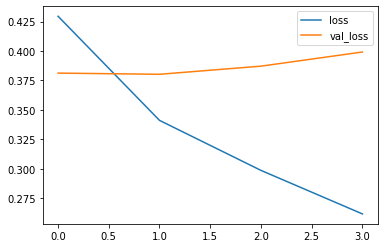

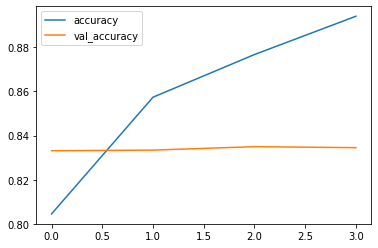

In [ ]:
pd.DataFrame(history2.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history2.history)[["accuracy", "val_accuracy"]].plot()
model2.summary()

**테스트 셋에서의 성능**

In [ ]:
print("model 2 test accuracy : {0:.4f}".format(model2.evaluate(seq_mte, y_test)[1]))

1847/1847 [==============================] - 179s 97ms/step - loss: 0.4010 - accuracy: 0.8356
model 2 test accuracy : 0.8356


조금 성능이 올라갔지만 거의 의미없는 수준이다.

### **Model 3 : Bidirectional LSTM with BahdanauAttention**

마지막으로 양방향 LSTM에서 지난 layer들의 모든 hidden state를 한 번 더 확인해서 놓친 유용한 정보가 없는지 확인하게끔 하는 attention 기법을 활용해 보겠다.

Attention에서는 특정 벡터에 집중할 수 있게 해 주는데, 여기서는 지난 hidden state중 유용한 정보가 있는지 확인하게끔 만들어 보았다.

**BahdanauAttention**

In [ ]:
import tensorflow as tf
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query):
        #query.shape = (batch_size, hidden_size)
        #hidden_with_time_axis.shape = (batch_size, 1, hidden_size)
        #위의 축 확장의 이유는 score(batch_size, max_len, hidden_size) 계산을 위해 덧셈을 할 때 차원 맞춰주기 위함
        hidden_with_time_axis = tf.expand_dims(query, 1)

        #score.shape == (batch_size, max_length = 35, 1)
        #아까는 (batch_size, max_length, hidden_size)였는데 hidden_size = 1이 된 이유 : score을 self.V에 적용하기 때문
        #self.V 적용 전 텐서 shape : (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        #attention_weights.shape == (batch_size, max_length = 35, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)

        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

BahdanauAttention을 사용하기 때문에 지금까지의 hidden state와 cell state를 저장한 다음 연결해주어야 함

Bidirectional LSTM은 순방향, 역방향 각각에서 hidden state와 cell state를 가짐

이를 위에서 정의한 어텐션으로 활용하려면 각각의 방향에서의 hidden, cell state를 연결해 주는 과정이 필요함

따라서 중간중간 state들을 받아와 객체에 저장하고, 이를 연결해 주는 작업이 필요하기 때문에 위와 같은 Sequential API가 아닌 Functional API로 만들어줄 예정.

In [ ]:
from keras.layers import Bidirectional, Concatenate
from keras.models import Model, Input

#Input layer은 입력 개수를 따로 지정해주어야 함
#우리는 데이터의 길이가 35가 되게끔 padding해 주었으니 아래와 같음
seq_input = Input(shape = (35,), dtype = "int32")
embedded = Embedding(35000, 50, input_length = 35)(seq_input)
lstm = Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True))(embedded)
lstm, f_h, f_c, b_h, b_c = Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True, return_state = True, recurrent_activation = "relu", recurrent_initializer = "glorot_uniform"))(lstm)
print(lstm.shape, f_h.shape, f_c.shape, b_h.shape, b_c.shape)

state_h = Concatenate()([f_h, b_h]) #hidden state
state_c = Concatenate()([f_c, b_c]) #cell state

attention = BahdanauAttention(32)
context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(20, activation = "relu")(context_vector)
dropout = Dropout(0.2)(dense1)
output = Dense(1, activation = "sigmoid")(dropout)
model3 = Model(inputs = seq_input, outputs = output)
model3.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

(None, 35, 256) (None, 128) (None, 128) (None, 128) (None, 128)


batch size와 epochs, validation split, callback는 아까와 동일하게 구성

In [ ]:
history3_1 = model3.fit(seq_mt, y_train, batch_size = 128, epochs = 15, validation_split = 0.2)

Epoch 1/15
862/862 [==============================] - 548s 636ms/step - loss: 0.4653 - accuracy: 0.7596 - val_loss: 0.3797 - val_accuracy: 0.8315
Epoch 2/15
862/862 [==============================] - 545s 633ms/step - loss: 0.3442 - accuracy: 0.8550 - val_loss: 0.3782 - val_accuracy: 0.8331
Epoch 3/15
862/862 [==============================] - 548s 636ms/step - loss: 0.3013 - accuracy: 0.8746 - val_loss: 0.3919 - val_accuracy: 0.8346
Epoch 4/15
862/862 [==============================] - 547s 635ms/step - loss: 0.2681 - accuracy: 0.8881 - val_loss: 0.3955 - val_accuracy: 0.8293
Epoch 5/15
862/862 [==============================] - 547s 635ms/step - loss: nan - accuracy: 0.5407 - val_loss: nan - val_accuracy: 0.5020
Epoch 6/15
862/862 [==============================] - 547s 635ms/step - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5020
Epoch 7/15
862/862 [==============================] - 549s 637ms/step - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 35, 50)       1750000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 35, 256)      183296      embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional [(None, 35, 256), (N 394240      bidirectional_14[0][0]           
______________________________________________________________________________________________

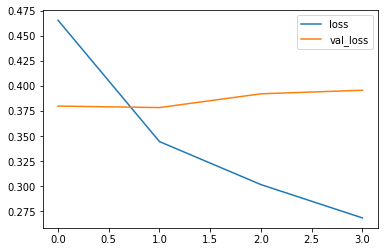

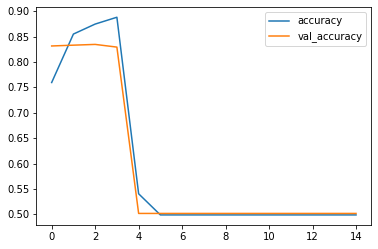

In [ ]:
pd.DataFrame(history3_1.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history3_1.history)[["accuracy", "val_accuracy"]].plot()
model3.summary()

In [ ]:
print("model 3 test accuracy : {0:.4f}".format(model3.evaluate(seq_mte, y_test)[1]))

1847/1847 [==============================] - 114s 62ms/step - loss: nan - accuracy: 0.4996
model 3 test accuracy : 0.4996


보다시피 epoch 3 이후로는 validation loss가 증가하고, 4 이후로는 아예 loss와 validation loss를 계산할 수 없게 된다.
따라서 마지막으로 위의 모델을 그대로 활용하되, epoch를 3으로 줄이기로 한다.

In [ ]:
seq_input = Input(shape = (35,), dtype = "int32")
embedded = Embedding(35000, 50, input_length = 35)(seq_input)
lstm = Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True))(embedded)
lstm, f_h, f_c, b_h, b_c = Bidirectional(LSTM(128, dropout = 0.2, return_sequences = True, return_state = True, recurrent_activation = "relu", recurrent_initializer = "glorot_uniform"))(lstm)
print(lstm.shape, f_h.shape, f_c.shape, b_h.shape, b_c.shape)

state_h = Concatenate()([f_h, b_h]) #hidden state
state_c = Concatenate()([f_c, b_c]) #cell state

attention = BahdanauAttention(32)
context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(20, activation = "relu")(context_vector)
dropout = Dropout(0.2)(dense1)
output = Dense(1, activation = "sigmoid")(dropout)
model3 = Model(inputs = seq_input, outputs = output)
model3.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

(None, 35, 256) (None, 128) (None, 128) (None, 128) (None, 128)


In [ ]:
history3_2 = model3.fit(seq_mt, y_train, batch_size = 128, epochs = 3)

Epoch 1/3
1078/1078 [==============================] - 667s 609ms/step - loss: 0.5481 - accuracy: 0.6751
Epoch 2/3
1078/1078 [==============================] - 658s 610ms/step - loss: 0.3471 - accuracy: 0.8514
Epoch 3/3
1078/1078 [==============================] - 655s 607ms/step - loss: 0.3038 - accuracy: 0.8756


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 35, 50)       1750000     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 35, 256)      183296      embedding_10[0][0]               
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional [(None, 35, 256), (N 394240      bidirectional_16[0][0]           
____________________________________________________________________________________________

In [ ]:
print("model 3 test accuracy : {0:.4f}".format(model3.evaluate(seq_mte, y_test)[1]))

1847/1847 [==============================] - 118s 62ms/step - loss: 0.3718 - accuracy: 0.8380
model 3 test accuracy : 0.8380


마지막 모델에서 epoch를 3으로 지정하고 돌린 최종 결과는 0.8380이다.

시간이 부족해서 아쉬운 부분이 있었지만 다음에 보완할 부분은

1. 웹크롤링 더 배워서 1-10까지의 리뷰 평점 예측

2. Attention기법의 다양한 예시와 활용예 알아보기

3. batch size와 learning rate간의 관계